In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from yellowbrick.cluster import KElbowVisualizer

# Anomaly Detection with Clustering

[KDDCup99](https://www.kaggle.com/datasets/galaxyh/kdd-cup-1999-data)

In [2]:
data = pd.read_csv('../../datasets/KDDCup99.csv.gz')

In [3]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494020.000000,4.940200e+05,4.940200e+05,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,...,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000
mean,47.979400,3.025616e+03,8.685308e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148245,0.010212,...,232.471248,188.666052,0.753781,0.030906,0.601936,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.747185,9.882191e+05,3.304003e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355343,1.798328,...,64.744601,106.040205,0.410780,0.109259,0.481309,0.042133,0.380593,0.380920,0.230590,0.230141
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
Y = data.iloc[:,-1] 
X = data.iloc[:,:-1]

# Categorical features
cat_features = ['protocol_type', 'service', 'flag']

# One-Hot-Encoding 
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X[cat_features])

new_feature_names = encoder.get_feature_names_out(input_features=cat_features)

# Add the encoded array to the data and assign the new column names
X_encoded_df = pd.DataFrame(X_encoded, columns=new_feature_names)
X = pd.concat([X.drop(columns=cat_features), X_encoded_df], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(len(X_train))

395216


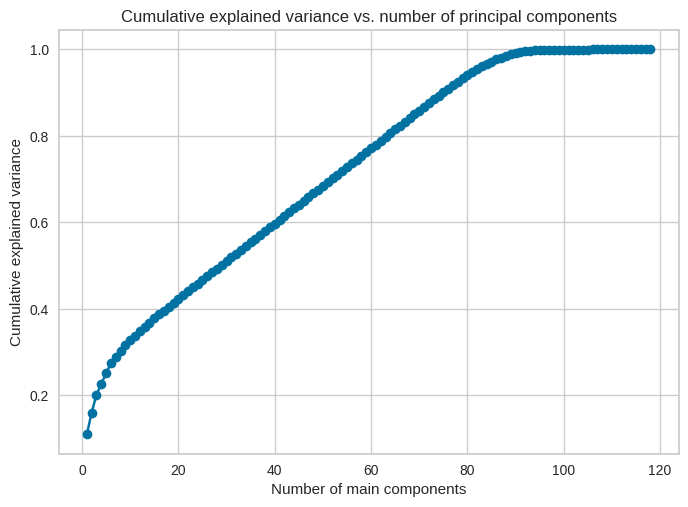

Optimal number of main components: 64


In [5]:
# Scaling the data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA(random_state=42)
pca.fit(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of main components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance vs. number of principal components')
plt.grid(True)
plt.show()

threshold = 0.80
n_components = np.argmax(cumulative_variance >= threshold) + 1

print(f'Optimal number of main components: {n_components}')

pca = PCA(n_components=n_components, random_state=42) 
X_pca = pca.fit_transform(X_scaled)

feature_weights = pca.components_
scaled_weights = feature_weights.T * np.sqrt(pca.explained_variance_)

relevant_features = [] 
index_selected_features = [] 
for i, weights in enumerate(scaled_weights):
    component_features = []
    for j, weight in enumerate(weights):
        if abs(weight) > 0.4:  
            component_features.append(j)  
    relevant_features.append(component_features)

for i, component_features in enumerate(relevant_features):
    for feature_index in component_features:
        index_selected_features.append(feature_index)

index_selected_features = list(set(index_selected_features))
X_scaled = X_train.iloc[:, index_selected_features]  

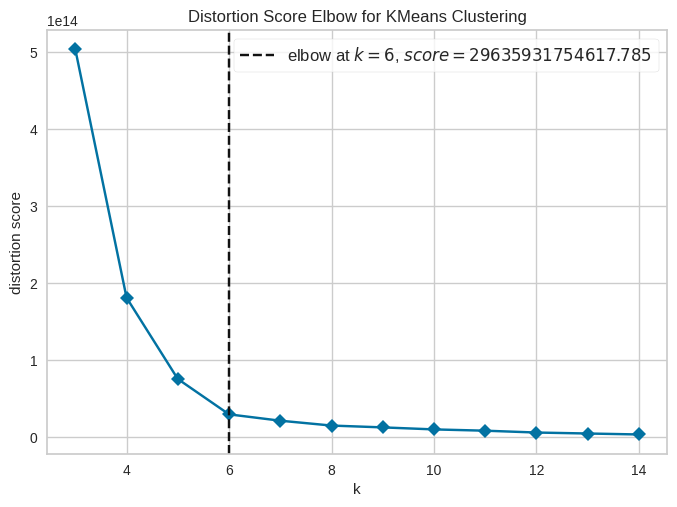

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
# Instantiate the clustering model and visualizer
model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=(3, 15),  timings=False)

visualizer.fit(X_train)  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [7]:
k = 6
kmeans = KMeans(n_clusters=k, n_init='auto')
kmeans.fit(X_train)

distances = kmeans.transform(X_train)

cluster_indices = kmeans.labels_


mask = (cluster_indices[:, None] == np.arange(distances.shape[1]))
distances[~mask] = 0

dictionary = {i: column for i, column in enumerate(zip(*distances))}


mean_distances = [sum(values) / len(values) for key, values in dictionary.items()]
thresholds = np.array(mean_distances)  # thresholds als NumPy-Array anpassen

print(f'thresholds: {thresholds}')

outliers = np.any(np.array(distances) > thresholds, axis=1)  
print(f'{outliers}')

thresholds: [1.60921026e+03 0.00000000e+00 1.26434573e-01 1.08510803e+01
 2.41631374e+01 4.35952914e-01]
[False False False ... False  True False]


In [8]:
filtered_outlier = y_train[outliers]

filtered_labels = filtered_outlier[filtered_outlier != 'normal']

count = (len(filtered_outlier) - len(filtered_labels)) / len(filtered_outlier)

print(f'Accuracy: {count}')

Accuracy: 0.9207460048338805
